In [1]:
# ensure imports from src.* work regardless of where Jupyter launched
import sys
from pathlib import Path
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import json, math
import numpy as np
import matplotlib.pyplot as plt
from src.runner import solve_fixed_step

def periodic_laplacian_1d(u: np.ndarray, dx: float) -> np.ndarray:
    return (np.roll(u, -1) - 2.0*u + np.roll(u, 1)) / (dx*dx)

def heat_rhs(t, u, p):
    return p["nu"] * periodic_laplacian_1d(u, p["dx"])

def gaussian_periodic(x, x0, sigma, amp=1.0, L=1.0):
    s = np.zeros_like(x)
    for k in range(-2, 3):
        s += amp * np.exp(-0.5*((x - x0 + k*L)/sigma)**2)
    return s

def analytic_heat_gaussian_periodic(x, x0, sigma0, amp, nu, t, L=1.0):
    if t == 0.0:
        return gaussian_periodic(x, x0, sigma0, amp, L=L)
    sigma_t = math.sqrt(sigma0*sigma0 + 2.0*nu*t)
    scale = amp * (sigma0 / sigma_t)
    s = np.zeros_like(x)
    for k in range(-2, 3):
        s += scale * np.exp(-0.5*((x - x0 + k*L)/sigma_t)**2)
    return s

# experiment config
L = 1.0
nu = 1e-3
x0 = 0.5*L
sigma0 = 0.05*L
amp = 1.0
T = 0.05
Ns = [64, 128, 256, 512]
cfl_target = 0.4

results_dir = ROOT / "outputs" / "validation_heat1d"
results_dir.mkdir(parents=True, exist_ok=True)

dxs, errs = [], []

for N in Ns:
    x = np.linspace(0.0, L, N, endpoint=False)
    dx = L / N
    u0 = gaussian_periodic(x, x0, sigma0, amp=amp, L=L)

    dt = cfl_target * 0.5 * dx*dx / nu
    steps = int(np.ceil(T / dt))
    dt = T / steps

    out_dir = results_dir / f"N{N}"
    out_dir.mkdir(parents=True, exist_ok=True)

    sol = solve_fixed_step(
        f=heat_rhs,
        t_span=(0.0, T),
        y0=u0,
        dt=dt,
        method="rk4",
        params={"nu": nu, "dx": dx},
        save_every=max(1, steps // 20),
        metrics_out_dir=out_dir,
        norm_grid=(dx, None),
        cfl_specs={"diff": {"type": "diffusion", "dt": dt, "dx": dx, "nu": nu, "dim": 1}},
    )

    u_num = sol.y[-1]
    u_ref = analytic_heat_gaussian_periodic(x, x0, sigma0, amp, nu, T, L=L)
    err = float(np.sqrt(dx * np.sum((u_num - u_ref)**2)))

    # write unified artifacts inside out_dir
    np.savetxt(out_dir / "u_final.csv", u_num, delimiter=",")
    np.savetxt(out_dir / "x.csv", x, delimiter=",")
    plt.figure()
    plt.plot(x, u0, label="initial")
    plt.plot(x, u_ref, label="analytic @T")
    plt.plot(x, u_num, "--", label="numeric @T")
    plt.legend(); plt.tight_layout()
    plt.savefig(out_dir / "u_final.png", dpi=160)
    plt.close()

    # update metrics.json with error
    mfile = out_dir / "metrics.json"
    with mfile.open("r", encoding="utf-8") as f:
        m = json.load(f)
    m.setdefault("extras", {})["error_L2_at_T"] = err
    with mfile.open("w", encoding="utf-8") as f:
        json.dump(m, f, indent=2)

    dxs.append(dx)
    errs.append(err)

print("Collected (N, dx, error):")
for N, dx, e in zip(Ns, dxs, errs):
    print(f"N={N:4d}  dx={dx:.6f}  L2_error={e:.8f}")


Collected (N, dx, error):
N=  64  dx=0.015625  L2_error=0.00011226
N= 128  dx=0.007812  L2_error=0.00002832
N= 256  dx=0.003906  L2_error=0.00000710
N= 512  dx=0.001953  L2_error=0.00000178


Estimated order (slope) ≈ 1.99


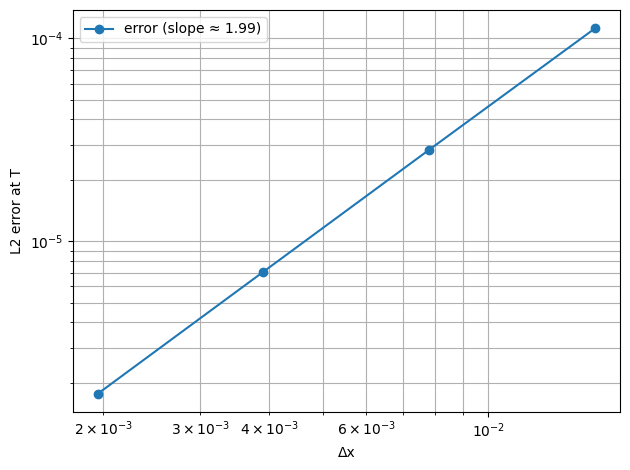

In [2]:
import numpy as np
import matplotlib.pyplot as plt

dxs_arr = np.array(dxs)
errs_arr = np.array(errs)

p = np.polyfit(np.log(dxs_arr), np.log(errs_arr), 1)[0]
print(f"Estimated order (slope) ≈ {p:.2f}")

plt.figure()
plt.loglog(dxs_arr, errs_arr, "o-", label=f"error (slope ≈ {p:.2f})")
plt.xlabel("Δx")
plt.ylabel("L2 error at T")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.savefig(results_dir / "convergence_heat1d.png", dpi=160)
plt.show()
